In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from multiprocessing import Pool, shared_memory
from functools import partial
import tqdm

from scipy import stats

from lens_map import *
import gaussian_source as src
import random_deflection


arcmin = np.pi/(180*60.)
arcsec = np.pi/(180*60.*60.)
microarcsec = 1e-6*arcsec

pc_in_km = 3.08568e+13
Gpc_in_km = 1e9*pc_in_km
AU_in_km = 1.49598e+08 

In [2]:

# Parameters that determine the lens equation near the caustic - see Schneider, Ehlers and Falco Ch. 6
phi_11, phi_22 = 0.8, 0.0 # This makes the caustic a horizontal line in the source plane

# These are chosen such that the caustic is well approximated by a parabola, i.e. so that we can compare with analytics
phi_111, phi_112, phi_122, phi_222 = 0.06/5., 0.05/5., 0.03/5., 0.05/5.

# This parameter controls the magnification
g = 2 / (phi_11 ** 2 * phi_222)

caustic_params = {'phi_11':phi_11, 'phi_22':phi_22, 'phi_111':phi_111, 'phi_112':phi_112, 'phi_122':phi_122, 'phi_222':phi_222}
ps_params = {'M':2e-6, 'c': 1200, 'DL': 1.35, 'DS':1.79, 'DLS':0.95, 'dm_mass_fraction':1}



def pool_func(shared_y1_info, shared_y2_info, pixel_size_lns, rad, src_pos):

    shared_y1_name, y1_shape = shared_y1_info
    shared_y2_name, y2_shape = shared_y2_info
    existing_shm_y1 =  shared_memory.SharedMemory(name=shared_y1_name)
    existing_shm_y2 =  shared_memory.SharedMemory(name=shared_y2_name)
    
    y1 =  np.ndarray(y1_shape,dtype=np.float64,buffer=existing_shm_y1.buf)
    y2 =  np.ndarray(y2_shape,dtype=np.float64,buffer=existing_shm_y2.buf)
    
    lensed_source = src.gaussian_source(y1, y2, rad, c=src_pos)

    # Calculate magnifications
    intensity_norm = 1. # assume it is normalized #np.sum(a_gaussian) * ys * ys
    mag = np.sum(lensed_source) * (pixel_size_lns ** 2) / intensity_norm
    return(mag)

def generate_lightcurve(num_pixel=1001, include_substructure=True):

    # Size and discretization of the lens and source planes
    num_pixel_lns, num_pixel_src = num_pixel, num_pixel # Number of pixels in both planes
    half_size_lns, half_size_src = 4.0, 0.1 # Half size of the lens and source planes
    pixel_size_lns, pixel_size_src = 2.0 * half_size_lns / (num_pixel_lns - 1), 2.0 * half_size_src / (num_pixel_src - 1) # horizontal and vertical physical pixel size
    
    domain_size = 2*half_size_lns
    
    # Random noise - make sure parameters supplied to power spectrum are in radians
    deflection_params = {'pixel_size_in_rad':pixel_size_lns*microarcsec, 'num_pixel':num_pixel_lns, 'area_in_rad_sq': (2.*half_size_lns*microarcsec)**2} 
    #Parameters needed for power spectrum here

    deflection_params['ps_params'] = ps_params
    if include_substructure:
        # the output is in rad, so convert it to microarcsec
        caustic_params['random_deflection'] = random_deflection.generate_random_field(deflection_params)/microarcsec
    else:
        caustic_params['random_deflection'] = None
    
    # indices for the lens plane pixels.
    # Note: arrays are indexed as by [j1,j2], so j2 (j1) indexes horizontal (vertical) directions
    j1, j2 = np.mgrid[0:num_pixel_lns, 0:num_pixel_lns] 
    
    # this maps pixels indices to physical coord as [0,0] -> (-L,L), [0,N-1]-> (L,L) etc
    x1, x2 = pixel_to_pos(j2, -half_size_lns, pixel_size_lns), pixel_to_pos(j1, half_size_lns, -pixel_size_lns)
    
    y1, y2 = lens_mapping(x1, x2, caustic_params)
    
    # Convert deflected coordinates to source plane pixels
    i1, i2 = pos_to_pixel(y2, half_size_src, -pixel_size_src), pos_to_pixel(y1, -half_size_src, pixel_size_src)


    xpos, rad = 0.0, 0.01/3
    ypos_values = np.linspace(0.05,-0.01,400)
    src_positions = np.array([[xpos,ypos] for ypos in ypos_values])
    magnifications = np.zeros_like(ypos_values)
    
    
    # create shared memory so that large static arrays don't get copied to workers
    shm_y1 = shared_memory.SharedMemory(create=True, size=y1.nbytes)
    shm_y2 = shared_memory.SharedMemory(create=True, size=y2.nbytes)
    y1_shared = np.ndarray(y1.shape, dtype=y1.dtype, buffer=shm_y1.buf)
    y1_shared[:] = y1[:]
    y2_shared = np.ndarray(y2.shape, dtype=y2.dtype, buffer=shm_y2.buf)
    y2_shared[:] = y2[:]
    y1_shape = y1.shape
    y2_shape = y2.shape

    magnifications = []
    with Pool() as p:
        #for mag in tqdm.tqdm(p.imap(func=partial(pool_func, [shm_y1.name, y1_shape], [shm_y2.name,y2_shape], rad), iterable=src_positions), total=len(src_positions)):    
        for mag in p.imap(func=partial(pool_func, [shm_y1.name, y1_shape], [shm_y2.name,y2_shape], pixel_size_lns, rad), iterable=src_positions):        
            magnifications.append(mag)
    magnifications = np.array(magnifications)

    return(magnifications)

## Testing

In [3]:
magnifications = generate_lightcurve(num_pixel=1501)
magnifications_no_substructure = generate_lightcurve(num_pixel=1501,include_substructure=False)

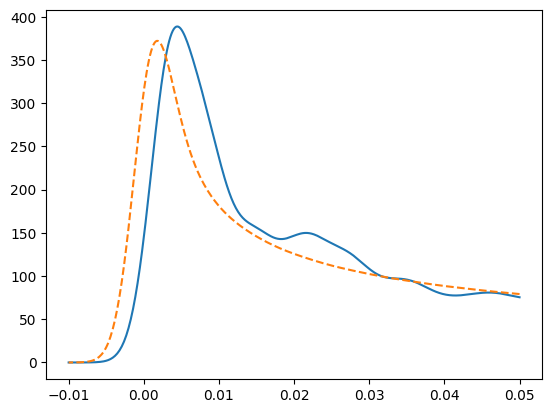

In [4]:
plt.plot(np.linspace(0.05,-0.01,400),magnifications)
plt.plot(np.linspace(0.05,-0.01,400),magnifications_no_substructure,'--')

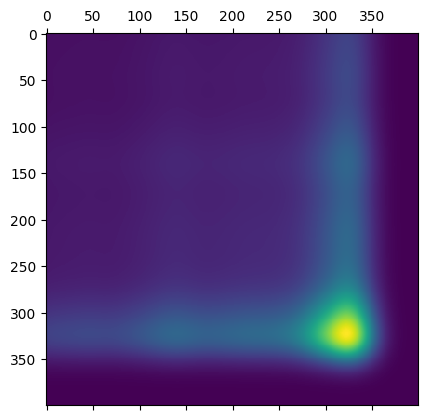

In [19]:
outer_product = np.outer(magnifications,magnifications)
plt.matshow(outer_product)

## Autocovariance with substructure

In [63]:
lightcurve_sample = [generate_lightcurve(num_pixel=1501) for i in tqdm.tqdm(range(100))]

100%|█████████████████████████████████████████| 100/100 [21:33<00:00, 12.94s/it]


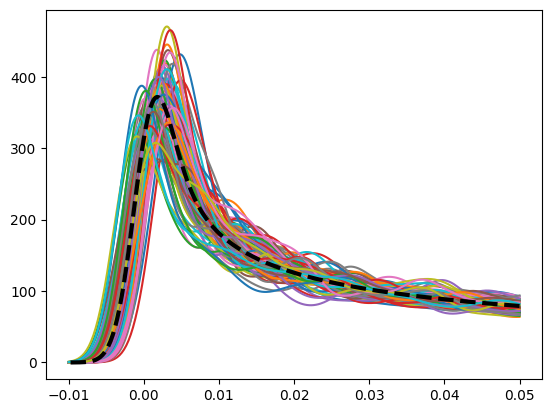

In [64]:
ypos_values = np.linspace(0.05,-0.01,400)
rad = 0.01/3
analytic = [np.sqrt(g / rad) * src.analytic_gaussian_source_magnification(-ypos / rad) for ypos in ypos_values]

for ls in lightcurve_sample:
    plt.plot(ypos_values,ls)

plt.plot(ypos_values, analytic,'--',c='k',lw=3)


In [65]:
total_outer = np.zeros((len(lightcurve_sample[0]),len(lightcurve_sample[0])))
means = np.mean(lightcurve_sample,axis=0)
for mag in lightcurve_sample:
    total_outer += np.outer(mag,mag)/len(lightcurve_sample)
autocov_mat = total_outer - np.outer(means,means)

In [66]:
len(lightcurve_sample), lightcurve_sample[0].shape

(100, (400,))

Text(0.5, 1.0, 'Autocovariance Matrix')

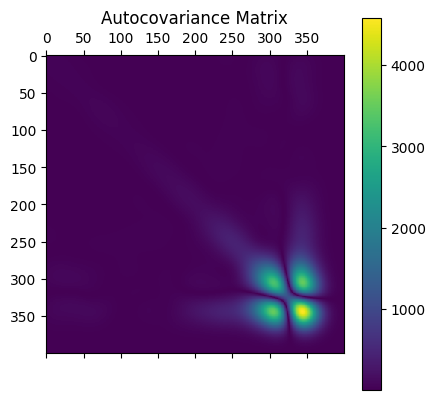

In [67]:
plt.matshow(np.abs(autocov_mat))
plt.colorbar()
plt.title('Autocovariance Matrix')

In [68]:
np.max(autocov_mat)

4579.600307034776

In [33]:
np.min(autocov_mat)

-5421.753412189624

In [69]:
total_outer = np.zeros((len(lightcurve_sample[0]),len(lightcurve_sample[0]),len(lightcurve_sample[0])))
means = np.mean(lightcurve_sample,axis=0)
for mag in lightcurve_sample:
    total_outer += mag[:,None,None]*mag[None,:,None]*mag[None,None,:] \
                 - means[:,None,None]*mag[None,:,None]*mag[None,None,:]\
                 - mag[:,None,None]*means[None,:,None]*mag[None,None,:]\
                 - mag[:,None,None]*mag[None,:,None]*means[None,None,:]\

total_outer += 2.*means[:,None,None]*means[None,:,None]*means[None,None,:]

three_pt_correlation = total_outer

In [8]:
three_pt_correlation.shape

(400, 400, 400)

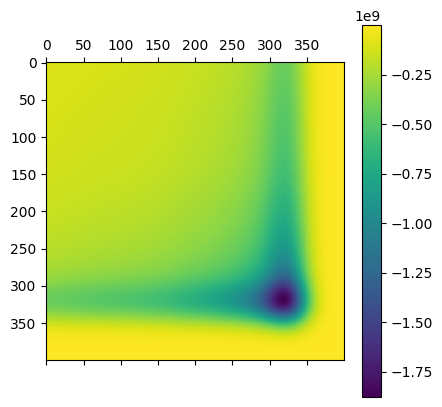

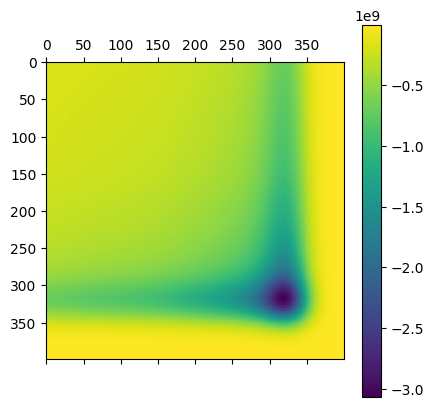

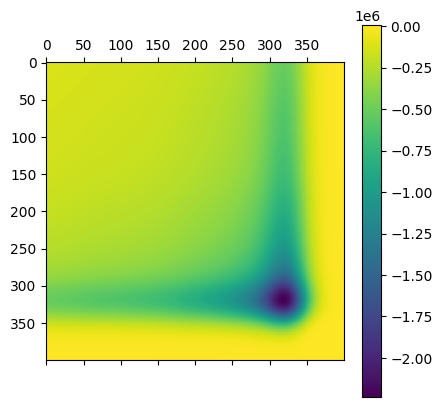

In [70]:
plt.matshow(three_pt_correlation[0,:,:])
plt.colorbar()
plt.show()
plt.matshow(three_pt_correlation[200,:,:])
plt.colorbar()
plt.show()
plt.matshow(three_pt_correlation[399,:,:])
plt.colorbar()
plt.show()


## Autocovariance without any substructure

this should vanish since the lightcurves should be completely deterministic. The pixel size is important: if there are too few pixels we do not get smooth results because there are not enough rays to resolve the source

In [20]:
lightcurve_sample = [generate_lightcurve(num_pixel=1501, include_substructure=False) for i in tqdm.tqdm(range(100))]

100%|█████████████████████████████████████████| 100/100 [20:22<00:00, 12.23s/it]


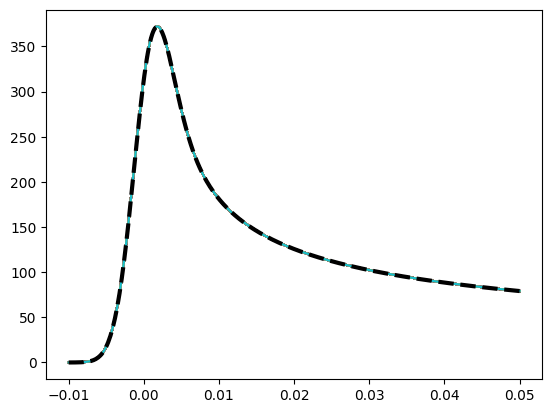

In [22]:
ypos_values = np.linspace(0.05,-0.01,400)
rad = 0.01/3
analytic = [np.sqrt(g / rad) * src.analytic_gaussian_source_magnification(-ypos / rad) for ypos in ypos_values]

for i in range(100):
    plt.plot(ypos_values,lightcurve_sample[i])

plt.plot(ypos_values, analytic,'--',c='k',lw=3)


In [23]:
total_outer = np.zeros((len(lightcurve_sample[0]),len(lightcurve_sample[0])))
means = np.mean(lightcurve_sample,axis=0)
for mag in lightcurve_sample:
    total_outer += np.outer(mag,mag)/len(lightcurve_sample)
autocov_mat = total_outer - np.outer(means,means)

Text(0.5, 1.0, 'Autocovariance Matrix')

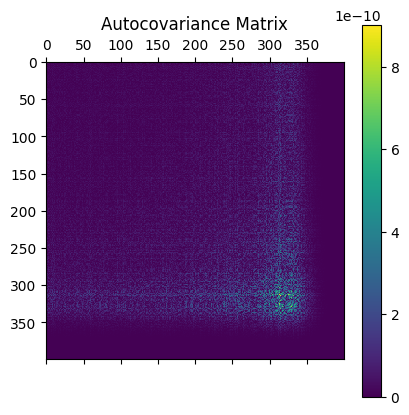

In [24]:
plt.matshow(np.abs(autocov_mat))
plt.colorbar()
plt.title('Autocovariance Matrix')

In [25]:
np.max(autocov_mat)

8.585629984736443e-10

## Perturbative Calculation 

In the original perturbative code things are expressed in terms of time. Here for simplicity we will just express everything in terms of distances to avoid introducing another parameter (the relative transverse velocity)

In [3]:
from scipy import interpolate
def get_mu_gaussian_source(y, params):
    peak_mag,  r_source_angular = params

    return(np.array([peak_mag*src.analytic_gaussian_source_magnification(-ypos/r_source_angular) for ypos in y]))


c_sample = np.geomspace(1e1, 1e4, 101)
universal_autocorrelator = np.load("../CausticMicrolensing/Josh/universal_autocorrelator.npy")


def get_universal_interpolator(c):
    """
    For a given value of the concentration parameter construct a function that computes the autocorrelation function 
    for the signal for a substructure mass M and at lag r.
    """
    min_index = np.abs(c_sample-c).argmin()
    interpolator = interpolate.interp1d(universal_autocorrelator[min_index, 0], universal_autocorrelator[min_index, 1],
                                    fill_value = (universal_autocorrelator[min_index, 0, 0], 0),
                                    kind = 'cubic')    

    def universal_interpolator(M, r):
        return M**(1/3)*interpolator(r/M**(1/3))


    return(universal_interpolator)

def smooth_max(x):
    x = np.asarray(x)
    return(np.sum(x*np.exp(x))/np.sum(np.exp(x)))
"""
def smooth_max(x, p=5):
    x = np.asarray(x)
    return(np.power(np.sum(np.power(x,p)),1./p))
"""
def gen_cov(params, y_evals):
    """
    y_evals = angualr coordinates of the source in the source plane
    """
    Nt = len(y_evals)

    phi_222 = params['phi_222']
    M = params['M']
    c = params['c']
    DS = params['DS'] # in Gpc
    angular_source_radius = params['R']
    
    universal_interpolator = get_universal_interpolator(c)
    
    # Assign values to the diagonal
    cov_mat = np.diag(universal_interpolator(M, 0)*np.ones((Nt)))

    """
    diag_indices = np.arange(Nt)
    for i in range(1, Nt):
        cov_mat[diag_indices[:-i], diag_indices[i:]] =  universal_interpolator(M, i*dt*v)
        cov_mat[diag_indices[i:], diag_indices[:-i]] =  universal_interpolator(M, i*dt*v)
    """

    
    
    for i in range(Nt):
        for j in range(i,Nt):
            
            # the length scale of the fluctuations is in the lens plane in microarcsec
            # the covariance can be non-positive definite if the wrong max function is used...
            r = np.abs(np.sqrt(2.*np.abs(y_evals[i])/phi_222)-np.sqrt(2.*np.abs(y_evals[j])/phi_222))
            #r = max(r, np.sqrt(2.*np.abs(angular_source_radius)/phi_222))
            r = smooth_max([r, np.sqrt(2.*np.abs(angular_source_radius)/phi_222)])
            # universal interpolator takes coord in km
            r *= microarcsec*DS*Gpc_in_km
            #print(r)
            cov_mat[i,j] = universal_interpolator(M, r)
            cov_mat[j,i] = cov_mat[i,j]
    return cov_mat


# Toy model functions
def generate_model(params, y_evals):
    """
    Returns the model mean and covariance matrix for parameters x and data time stamps t_evals
    """
    N = len(y_evals)

    angular_source_radius = params['R']
    phi_11 = params['phi_11'] 
    phi_222 = params['phi_222']
    M = params['M']
    c = params['c']
    frac = params['dm_mass_fraction']
    
    
    g = 2 / (phi_11 ** 2 * phi_222)
    peak_mag = np.sqrt(g / angular_source_radius)/1e4 
    mean_mu = get_mu_gaussian_source(y_evals, [1e4*peak_mag, angular_source_radius])


    # these are also model parameters in principle
    # Surface Density and Gradient
    #k0 = 0.83 # dimensionless
    A = phi_11**2 #4.*(1-k0)**2 # prefactor 
    
    cov = gen_cov(params,y_evals)

    

    # SHOULDNT THIS SCALE LIKE THE SQUARE OF CLUMPY DM?
    cov = frac**2 * A**2 * mean_mu[:, None]**2*cov*mean_mu[None, :]**2
    #cov = 0.5*(cov + cov.T)
    #print(np.max(cov-cov.T))
    return mean_mu, cov

In [4]:
phi_11, phi_222

(0.8, 0.01)

In [5]:
ps_params

{'M': 2e-06,
 'c': 1200,
 'DL': 1.35,
 'DS': 1.79,
 'DLS': 0.95,
 'dm_mass_fraction': 1}

In [6]:
# just picking whatever I plugged into the exact model
#params = 0.01/3, phi_11, phi_222, 2e-6, 1200, 1
params = {'R': 0.01/3, 'phi_11':phi_11, 'phi_222': phi_222, 'M': ps_params['M'], 'c': 1200, 'dm_mass_fraction': 1, 'DS' :ps_params['DS']}
y_evals = np.linspace(0.05,-0.01,400)
mean_mu, cov = generate_model(params, y_evals)

Text(0.5, 0, 'Source Plance Distance [$\\mu$as]')

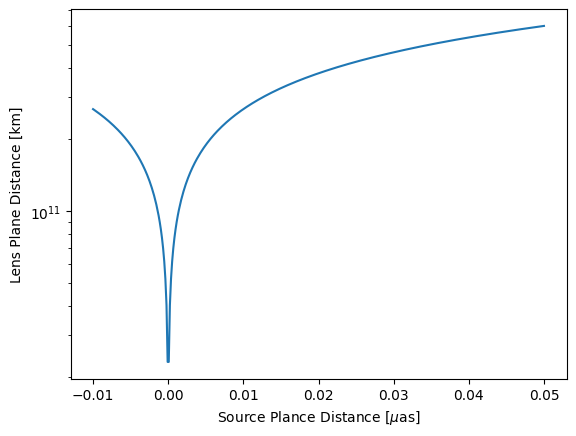

In [7]:
plt.plot(y_evals, microarcsec*params['DS']*Gpc_in_km*np.sqrt(np.abs(y_evals)/params['phi_222']))
plt.yscale('log')
plt.ylabel(r'Lens Plane Distance [km]')
plt.xlabel(r'Source Plance Distance [$\mu$as]')

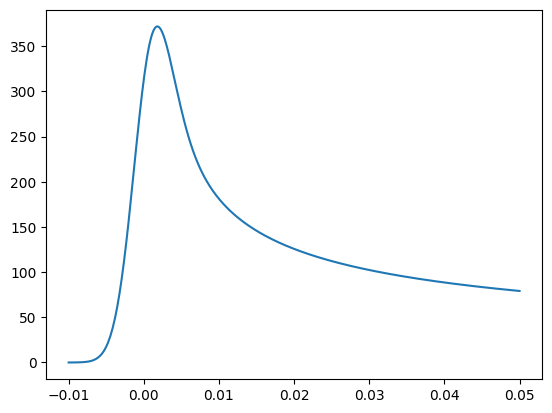

In [8]:
plt.plot(y_evals,mean_mu)

Text(0.5, 1.0, 'Autocovariance Matrix $\\langle \\delta\\mu_{i} \\delta\\mu_j \\rangle$')

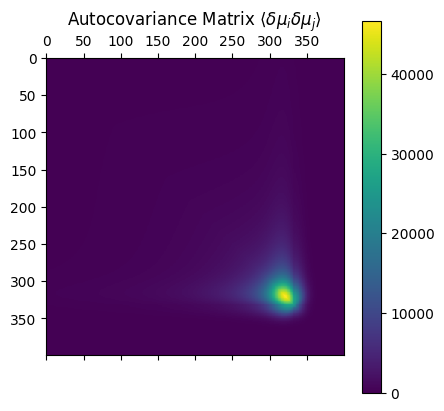

In [9]:
plt.matshow(np.abs(cov))
plt.colorbar()
plt.title(r'Autocovariance Matrix $\langle \delta\mu_{i} \delta\mu_j \rangle$')

In [21]:
total_outer = np.zeros((len(lightcurve_sample[0]),len(lightcurve_sample[0])))
means = np.mean(lightcurve_sample,axis=0)
for mag in lightcurve_sample:
    total_outer += np.outer(mag,mag)/len(lightcurve_sample)
autocov_mat = total_outer - np.outer(means,means)

In [12]:

generator = stats.multivariate_normal(mean = mean_mu, cov = cov, allow_singular = True)
lightcurve_sample = [generator.rvs() for i in tqdm.tqdm(range(100))]


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 21.76it/s]


In [ ]:
# even dumber:

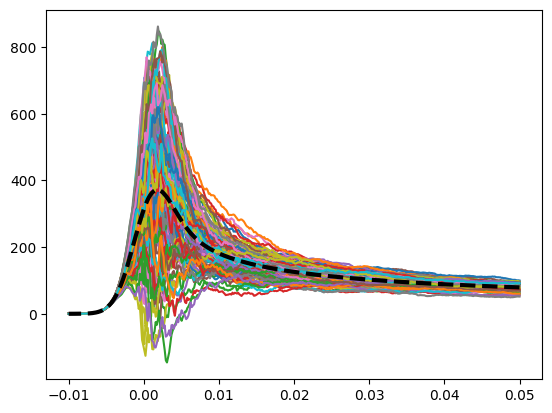

In [14]:
ypos_values = np.linspace(0.05,-0.01,400)
rad = 0.01/3
analytic = [np.sqrt(g / rad) * src.analytic_gaussian_source_magnification(-ypos / rad) for ypos in ypos_values]

for ls in lightcurve_sample:
    plt.plot(ypos_values,ls)

plt.plot(ypos_values, mean_mu,'--',c='k',lw=3)



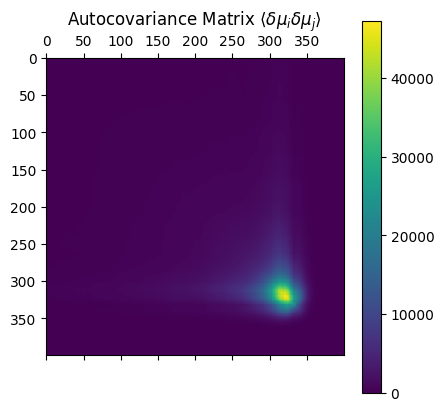

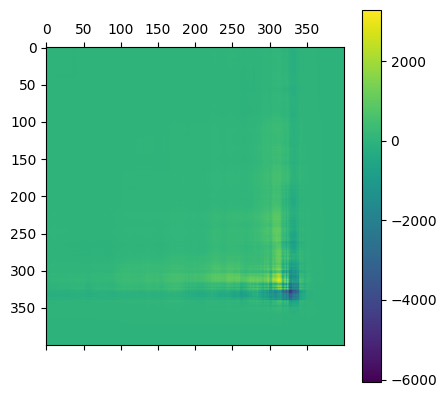

In [29]:
total_outer = np.zeros((len(lightcurve_sample[0]),len(lightcurve_sample[0])))
means = np.mean(lightcurve_sample,axis=0)
for mag in lightcurve_sample:
    total_outer += np.outer(mag,mag)/len(lightcurve_sample)
autocov_mat = total_outer - np.outer(means,means)

plt.matshow(np.abs(autocov_mat))
plt.colorbar()
plt.title(r'Autocovariance Matrix $\langle \delta\mu_{i} \delta\mu_j \rangle$')
plt.show()

plt.matshow(autocov_mat - cov)
plt.colorbar()

In [19]:
total_outer = np.zeros((len(lightcurve_sample[0]),len(lightcurve_sample[0]),len(lightcurve_sample[0])))
means = np.mean(lightcurve_sample,axis=0)
for mag in lightcurve_sample:
    total_outer += mag[:,None,None]*mag[None,:,None]*mag[None,None,:] \
                 - means[:,None,None]*mag[None,:,None]*mag[None,None,:]\
                 - mag[:,None,None]*means[None,:,None]*mag[None,None,:]\
                 - mag[:,None,None]*mag[None,:,None]*means[None,None,:]\

total_outer += 2.*means[:,None,None]*means[None,:,None]*means[None,None,:]

three_pt_correlation = total_outer/len(lightcurve_sample)

In [17]:
three_pt_correlation.nbytes/1e6

512.0

In [71]:
mardia_skewness(lightcurve_sample)

n_samples, n_features =  100 	 400


0.287467739032831

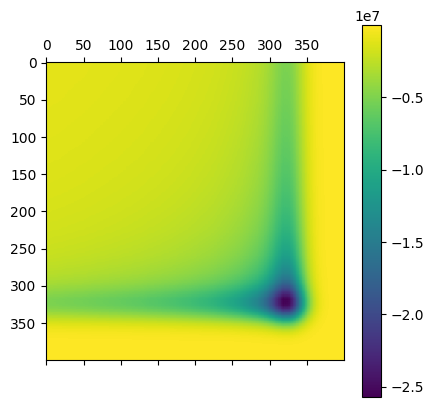

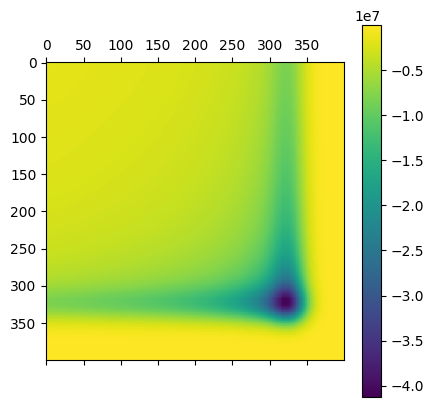

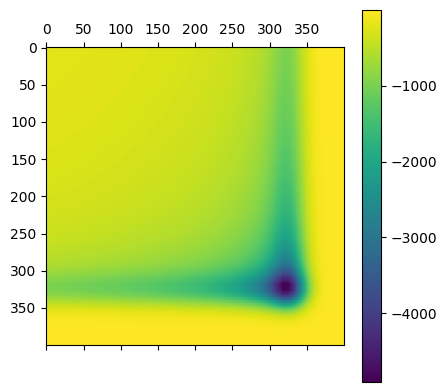

In [30]:
plt.matshow(three_pt_correlation[0,:,:])
plt.colorbar()
plt.show()
plt.matshow(three_pt_correlation[200,:,:])
plt.colorbar()
plt.show()
plt.matshow(three_pt_correlation[399,:,:])
plt.colorbar()
plt.show()


In [46]:
# chatgpt shit
# but seems consistent with https://real-statistics.com/multivariate-statistics/multivariate-normal-distribution/multivariate-normality-testing/
# 
def mardia_skewness(data):
    """
    Compute Mardia's multivariate skewness for a dataset.
    
    Parameters:
    data (numpy.ndarray): A 2D array of shape (n_samples, n_features),
                          where each row is a sample, and each column is a feature.
    
    Returns:
    float: Mardia's skewness measure.
    """
    # Ensure input is a NumPy array
    data = np.asarray(data)
    n_samples, n_features = data.shape
    print("n_samples, n_features = ", n_samples, "\t", n_features)
    
    # Compute the mean vector
    mean_vector = np.mean(data, axis=0)
    #plt.plot(mean_vector)
    
    # Compute the covariance matrix
    covariance_matrix = np.cov(data, rowvar=False)
    
    # Compute the inverse of the covariance matrix
    cov_inv = np.linalg.inv(covariance_matrix)
    
    # Center the data
    centered_data = data - mean_vector
    
    # Compute Mardia's skewness
    skewness_sum = 0
    for i in range(n_samples):
        for j in range(n_samples):
            mahalanobis_ij = centered_data[i] @ cov_inv @ centered_data[j]
            skewness_sum += mahalanobis_ij**3
    
    mardia_skewness = skewness_sum / (n_samples**2)

    chi_squared_mean = n_features*(n_features+1)*(n_features+2)/n_samples
    return mardia_skewness/chi_squared_mean

In [47]:
mardia_skewness(lightcurve_sample)

n_samples, n_features =  100 	 400


0.024214578734098654

In [60]:
# Example dataset with 100 samples and 3 features
np.random.seed(42)
data = np.random.multivariate_normal(
    mean=[0, 0, 0], 
    cov=[[1, 0.5, 0.2], [0.5, 1, 0.3], [0.2, 0.3, 1]], 
    size=1000
)

#data = rng.chisquare(3,(1000,3))
# Compute Mardia's skewness
skewness = mardia_skewness(data)
print(f"Mardia's Skewness: {skewness}")

n_samples, n_features =  1000 	 3
Mardia's Skewness: 0.510648257140154


In [50]:
data

array([[-0.15501329, -0.77467862, -0.10731697],
       [-1.40430305, -1.19802723, -0.75554378],
       [-1.13968619, -0.94908987, -1.61103776],
       ...,
       [-0.5411659 , -0.38324317, -0.44384568],
       [ 0.89970042,  0.67934846,  0.54059039],
       [ 1.04729397,  1.18018064,  0.45956236]])

In [54]:
np.random.Generator.chisquare(3, size=3)

TypeError: descriptor 'chisquare' for 'numpy.random._generator.Generator' objects doesn't apply to a 'int' object

In [58]:
rng = np.random.default_rng()

rng.chisquare(3,(1000,3))

array([[3.64896257, 0.45105337, 1.48074945],
       [2.8323426 , 1.31906034, 9.83246634],
       [2.06454788, 1.71743909, 2.09161553],
       ...,
       [5.36454967, 0.35541714, 2.90134388],
       [0.25931258, 2.41895382, 1.35613535],
       [0.57844317, 0.6119112 , 0.53919636]])